In [8]:
import time
import os
import sys
import itertools
import pandas as pd
import numpy as np
import mdtraj as md
from scipy.optimize import curve_fit
from scipy.interpolate import CubicSpline
from itertools import combinations
sys.path.append('/projects/prism/people/hzr104/software/BLOCKING')
from main import BlockAnalysis
import pickle as pkl
import matplotlib.pyplot as plt
from scipy import stats

In [10]:
def load_pickle(filename):
    with open(filename, 'rb') as f:
        loaded_obj = pkl.load(f)
        
    return loaded_obj

#energy maps
HALR = lambda r,s,l : 4*0.8368*l*((s/r)**12-(s/r)**6)
HASR = lambda r,s,l : 4*0.8368*((s/r)**12-(s/r)**6)+0.8368*(1-l)
HA = lambda r,s,l : np.where(r<2**(1/6)*s, HASR(r,s,l), HALR(r,s,l))
HASP = lambda r,s,l,rc : np.where(r<rc, HA(r,s,l)-HA(rc,s,l), 0)

def calcEnergyMap(t,df,prot,rc, weights):
    indices = t.top.select_pairs('all','all')
    mask = np.abs(indices[:,0]-indices[:,1])>1 #exclude >1, was used to exclude bonded pairs
    indices = indices[mask]
    d = md.compute_distances(t,indices) #distances between pairs for each frame
    # d[d>rc] = np.inf
    pairs = np.array(list(combinations(list(prot.fasta),2)))
    pairs = pairs[mask]
    sigmas = 0.5*(df.loc[pairs[:,0]].sigmas.values+df.loc[pairs[:,1]].sigmas.values)
    lambdas = 0.5*(df.loc[pairs[:,0]].lambdas.values+df.loc[pairs[:,1]].lambdas.values)
    emap = np.zeros(pairs.shape[0])
    d = d[:d.shape[0]//20*20]
    HASP_out = np.nan_to_num(HASP(d,sigmas[np.newaxis,:],lambdas[np.newaxis,:],rc))
    emap = np.average(HASP_out, weights=weights, axis=0)
    return indices, emap

def calcRg(t,residues,seq):
    fasta = list(seq.fasta)
    masses = residues.loc[fasta,'MW'].values
    # calculate the center of mass
    cm = np.sum(t.xyz*masses[np.newaxis,:,np.newaxis],axis=1)/masses.sum()
    # calculate residue-cm distances
    si = np.linalg.norm(t.xyz - cm[:,np.newaxis,:],axis=2)
    # calculate rg
    rgarray = np.sqrt(np.sum(si**2*masses,axis=1)/masses.sum())
    return rgarray

def calcRs(traj, weights):
    pairs = traj.top.select_pairs('all','all')
    d = md.compute_distances(traj,pairs)
    dmean = np.average(d, weights=weights, axis=0)
    nres = traj.n_atoms
    ij = np.arange(2,nres,1)
    diff = [x[1]-x[0] for x in pairs]
    dij = np.empty(0)
    for i in ij:
        dij = np.append(dij,dmean[diff==i].mean())
    ln_ij =  np.log(ij[ij>10])
    ln_dij = np.log(dij[ij>10])
    return ij,dij,ln_ij,ln_dij,np.mean(1/d,axis=1)

def analyse(residues,path,seq,weights):
    top = md.Topology()
    chain = top.add_chain()
    traj = md.load_xtc(path+'/traj_trimmed.xtc',top=path+'/top.pdb')
    N_res = traj.n_atoms
    fasta = list(seq.fasta)
    #fixing the trajectory to the middle of the box
    for resname in fasta:
        residue = top.add_residue(residues.loc[resname,'three'],chain)
        top.add_atom(residues.loc[resname,'three'], element=md.element.carbon, residue=residue)
    for i in range(N_res-1):
        top.add_bond(top.atom(i),top.atom(i+1))
    traj.top = top
    traj = traj.image_molecules(inplace=False, anchor_molecules=[set(traj.top.atoms)],make_whole=True)
    print('Number of frames: {:d}'.format(traj.n_frames))
    if os.path.exists(path+'/traj.gsd'):
        traj[-1].save_pdb(path+'/top.pdb')
        traj.save_xtc(path+'/traj.xtc')
        os.remove(path+'/traj.gsd')
    #skip first 10 frames
    #traj = traj[10:]
    #energy maps
    df_map = pd.DataFrame(index=range(traj.n_atoms),columns=range(traj.n_atoms),dtype=float)
    pairs, emap = calcEnergyMap(traj,residues,seq,2.0,weights)
    for k,(i,j) in enumerate(pairs):
        df_map.loc[i,j] = emap[k]
        df_map.loc[j,i] = emap[k]
    df_analysis = pd.DataFrame(index=['Rg','ete','rh','nu','R0','nu_ln','R0_ln'],columns=['value','error'])
    #rg
    rgarray = calcRg(traj,residues,seq)
    np.save(path+'/rg.npy',rgarray)
    block_rg = BlockAnalysis(rgarray, multi=1)
    block_rg.SEM()
    df_analysis.loc['Rg','value'] = np.average(rgarray, weights=weights)
    df_analysis.loc['Rg','error'] = block_rg.sem
    #ete
    ete = md.compute_distances(traj,atom_pairs=[[0,N_res-1]]).flatten()
    np.save(path+'/ete.npy',ete)
    block_ete = BlockAnalysis(ete, multi=1)
    block_ete.SEM()
    df_analysis.loc['ete','value'] = np.average(ete, weights=weights)
    df_analysis.loc['ete','error'] = block_ete.sem
    #nonlinear scaling exponent
    f = lambda x,R0,v : R0*np.power(x,v)
    ij,dij,ln_ij,ln_dij,invrij = calcRs(traj, weights)
    block_invrij = BlockAnalysis(invrij, multi=1)
    block_invrij.SEM()
    df_analysis.loc['rh','value'] = 1/(1-1/N_res)/np.average(invrij, weights=weights)
    df_analysis.loc['rh','error'] = block_invrij.sem/(1-1/N_res)/np.average(invrij, weights=weights)/np.average(invrij, weights=weights)
    np.save(path+'/rs.npy',dij)
    popt, pcov = curve_fit(f,ij[ij>10],dij[ij>10],p0=[.4,.5])
    df_analysis.loc['nu','value'] = popt[1]
    df_analysis.loc['nu','error'] = pcov[1,1]**0.5
    df_analysis.loc['R0','value'] = popt[0]
    df_analysis.loc['R0','error'] = pcov[0,0]**0.5
    #linear scaling exponent
    f = lambda x,R0,v : R0 + v*x
    popt, pcov = curve_fit(f, ln_ij, ln_dij, p0=[-1,.4],bounds=([-3,0],[1,1]))
    df_analysis.loc['nu_ln','value'] = popt[1]
    df_analysis.loc['nu_ln','error'] = pcov[1,1]**0.5
    df_analysis.loc['R0_ln','value'] = np.exp(popt[0])
    df_analysis.loc['R0_ln','error'] = np.exp(popt[0])*(pcov[0,0]**0.5) #error propagation
    return df_map,df_analysis,rgarray,ete

In [11]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [ ]:
residues = pd.read_csv('residues.csv').set_index('one',drop=False)
sequences = load_pickle('proteins.pkl')
weights = load_pickle('../BME_reweighting/BME_rew_SAXSonly/weights.pkl')
path = '.'
seq_name = 'ANAC046'

In [7]:
weights_uniform = np.array([1.0]*10000)
weights_uniform /= np.sum(weights_uniform)

In [8]:
df_map,df_analysis,rgarray,etearray = analyse(residues,path,sequences.loc[seq_name],weights_uniform)
df_analysis

Number of frames: 10000


,value,error
Rg,3.660388,0.008074
ete,8.619925,0.035583
rh,2.837992,0.003092
nu,0.511729,0.000416
R0,0.629494,0.00122
nu_ln,0.512756,0.000488
R0_ln,0.626643,0.001332


In [9]:
df_map_rew,df_analysis_rew,rgarray,etearray = analyse(residues,path,sequences.loc[seq_name],weights)
df_analysis_rew

Number of frames: 10000


,value,error
Rg,3.80977,0.008074
ete,9.250383,0.035583
rh,2.847179,0.003112
nu,0.561945,0.000905
R0,0.528288,0.002235
nu_ln,0.557972,0.000678
R0_ln,0.537774,0.001586


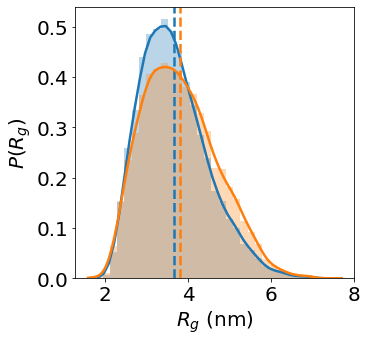

In [ ]:
fig = plt.figure(figsize=(5,5))

#KDE
kde_x = np.linspace( np.amin(rgarray)*0.9, np.amax(rgarray)*1.1, num = 50)
kde_y = stats.gaussian_kde(rgarray, bw_method = "silverman").evaluate(kde_x)

plt.hist(rgarray, density=True, color=colors[0], alpha=0.3, bins=30)
plt.axvline(x=np.average(rgarray), ls='--', linewidth=2.5, alpha=1, color=colors[0])
plt.plot(kde_x, kde_y, '-', linewidth=2.5, color=colors[0], label='Before rew.')

#KDE
kde_x_rew = np.linspace( np.amin(rgarray)*0.9, np.amax(rgarray)*1.1, num = 100 )
kde_y_rew = stats.gaussian_kde(rgarray, bw_method = "silverman", weights=weights).evaluate(kde_x_rew)

plt.hist(rgarray, weights=weights, density=True, color=colors[1], alpha=0.3, bins=30)
plt.axvline(x=np.average(rgarray, weights=weights), ls='--', linewidth=2.5, alpha=1, color=colors[1])
plt.plot(kde_x_rew, kde_y_rew, '-', linewidth=2.5, color=colors[1], label='After rew.')

plt.xlabel('$R_g$ (nm)', fontsize=20)
plt.ylabel('$P(R_g)$', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)

fig.savefig("../BME_reweighting/figures/Rg_distribution.png", bbox_inches='tight', pad_inches=1, dpi=400)
fig.savefig("../BME_reweighting/figures/Rg_distribution.pdf", bbox_inches='tight', pad_inches=1, dpi=400)

In [15]:
with open('../BME_reweighting/data_files/Rg_distribution.dat', 'w') as f:
    f.write('#Rg (nm)\tP\n')
    for Rg, P in zip(kde_x, kde_y):
        f.write(f'{Rg}\t{P}\n')
        
with open('../BME_reweighting/data_files/Rg_distribution_rew.dat', 'w') as f:
    f.write('#Rg (nm)\tP\n')
    for Rg, P in zip(kde_x_rew, kde_y_rew):
        f.write(f'{Rg}\t{P}\n')

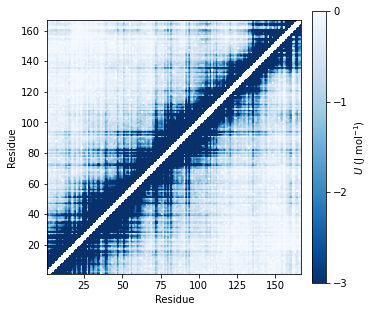

In [11]:
# Plot results 
fig = plt.figure(figsize=(5,5))

im = plt.imshow(df_map*1e3,extent=[1, df_map.shape[0], 1, df_map.shape[0]],origin='lower',aspect='equal',vmin=-3,vmax=0,cmap=plt.cm.Blues_r)
cb = plt.colorbar(im, label=r'$U$ (J mol$^{-1}$)',fraction=0.05, pad=0.04)
cb.set_ticks([0,-1,-2,-3])

plt.xlabel('Residue')
plt.ylabel('Residue')

fig.savefig("../BME_reweighting/figures/emap_uniform.png", bbox_inches='tight', pad_inches=1, dpi=400)
fig.savefig("../BME_reweighting/figures/emap_uniform.pdf", bbox_inches='tight', pad_inches=1, dpi=400)


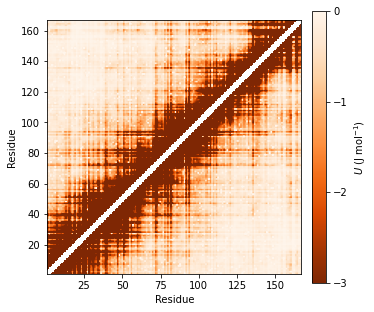

In [12]:
# Plot results 
fig = plt.figure(figsize=(5,5))

im = plt.imshow(df_map_rew*1e3,extent=[1, df_map_rew.shape[0], 1, df_map_rew.shape[0]],origin='lower',aspect='equal',vmin=-3,vmax=0,cmap=plt.cm.Oranges_r)
cb = plt.colorbar(im, label=r'$U$ (J mol$^{-1}$)',fraction=0.05, pad=0.04)
cb.set_ticks([0,-1,-2,-3])

plt.xlabel('Residue')
plt.ylabel('Residue')

fig.savefig("../BME_reweighting/figures/emap_rew.png", bbox_inches='tight', pad_inches=1, dpi=400)
fig.savefig("../BME_reweighting/figures/emap_rew.pdf", bbox_inches='tight', pad_inches=1, dpi=400)

25.585342


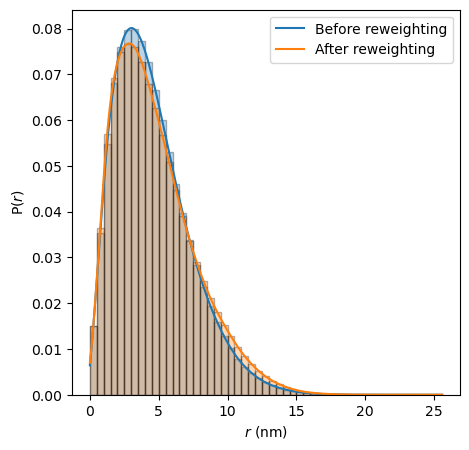

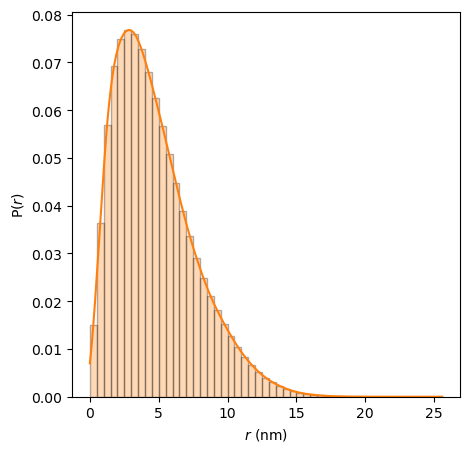

In [12]:
traj = md.load('/projects/prism/people/hzr104/ANAC046/Simulations/traj_AA.xtc', top='/projects/prism/people/hzr104/ANAC046/Simulations/top_AA.pdb')
atom_pairs= np.array([[i,j] for i in range(len(list(traj.top.atoms))) for j in range(len(list(traj.top.atoms)))])
dists = md.compute_distances(traj, atom_pairs)
#This takes a while to run
dists_flat = dists.flatten()
dmax = np.amax(dists_flat)
bins = np.arange(np.amin(dists_flat), int(np.amax(dists_flat)+1), 0.5)
print(dmax)
dists_hist_vs_frame = []
for i in range(len(dists)):
    dists_hist_vs_frame.append(np.histogram(dists[i,:], bins=bins, density=True)[0])
dists_hist_avg = np.average(dists_hist_vs_frame, axis=0)
dists_hist_avg /= np.sum(dists_hist_avg)
dists_hist_avg_rew = np.average(dists_hist_vs_frame, axis=0, weights=weights)
dists_hist_avg_rew /= np.sum(dists_hist_avg_rew)
fig = plt.figure(figsize=(5,5))

x_plot = [np.average([bins[i], bins[i+1]]) for i in range(len(bins[:-1]))]

#Smoothen histogram with cubic splines
cs = CubicSpline(x_plot, dists_hist_avg)
x_cs = np.linspace(0, dmax, 500)
plt.plot(x_cs, cs(x_cs), label='Before reweighting', color=colors[0])

plt.bar(x_plot, dists_hist_avg, edgecolor='black', width=0.5, alpha=0.3, color=colors[0])


#Smoothen histogram with cubic splines
cs_rew = CubicSpline(x_plot, dists_hist_avg_rew)
plt.plot(x_cs, cs_rew(x_cs), label='After reweighting', color=colors[1])

plt.bar(x_plot, dists_hist_avg_rew, edgecolor='black', width=0.5, alpha=0.3, color=colors[1])

plt.xlabel('$r$ (nm)')
plt.ylabel('P($r$)')

plt.legend()

fig.savefig(f"../BME_reweighting/figures/pr_beforeafterrew.png", bbox_inches='tight', pad_inches=1, dpi=400)
fig.savefig(f"../BME_reweighting/figures/pr_beforeafterrew.pdf", bbox_inches='tight', pad_inches=1, dpi=400)
fig = plt.figure(figsize=(5,5))

plt.plot(x_cs, cs_rew(x_cs), label='After reweighting', color=colors[1])

plt.bar(x_plot, dists_hist_avg_rew, edgecolor='black', width=0.5, alpha=0.3, color=colors[1])

plt.xlabel('$r$ (nm)')
plt.ylabel('P($r$)')

fig.savefig(f"../BME_reweighting/figures/pr.png", bbox_inches='tight', pad_inches=1, dpi=400)
fig.savefig(f"../BME_reweighting/figures/pr.pdf", bbox_inches='tight', pad_inches=1, dpi=400)

with open('../BME_reweighting/data_files/Pr_structures.dat', 'w') as f:
    for r,pr in zip(x_plot,dists_hist_avg_rew):
        f.write(f'{r:.8f}\t{pr:.8f}\n')
